In [42]:
#hide
from utils import *
from fastai2.vision.widgets import *

# From model to production

## The practice of deep learning

To download images with Bing Image Search, you should sign up at Microsoft for *Bing Image Search*. You will be given a key, which you can either paste here, replacing "XXX":

In [135]:
key = '8e25f14c1c214baa9040b20139296fe6'


In [12]:
results = search_images_bing(key, 'smiley emoji')
ims = results.attrgot('content_url')
len(ims)

150

In [87]:
ims

(#150) ['http://www.i2symbol.com/pictures/emojis/d/e/c/7/dec71f1888f42c9f92c55889564d64ab.png','https://upload.wikimedia.org/wikipedia/commons/thumb/e/ea/Breathe-face-smile.svg/1200px-Breathe-face-smile.svg.png','https://i.ebayimg.com/images/i/222077111380-0-1/s-l1000.jpg','https://cdn.pixabay.com/photo/2019/02/19/19/45/thumbs-up-4007573_960_720.png','https://i.pinimg.com/originals/28/08/36/2808366229c6e83fae618ae25a94ae28.png','https://i.ebayimg.com/images/i/322066540317-0-1/s-l1000.jpg','https://images-eu.ssl-images-amazon.com/images/I/71IzFyBoTuL.png','http://i.infopls.com/images/emoji-smiley.jpg','https://images-na.ssl-images-amazon.com/images/I/81S3Gd%2B5ZqL.png','https://i.pinimg.com/originals/da/4b/dc/da4bdcb51888e39f7af678430dfaa0d0.png'...]

In [ ]:
#hide
ims = ['http://3.bp.blogspot.com/-S1scRCkI3vY/UHzV2kucsPI/AAAAAAAAA-k/YQ5UzHEm9Ss/s1600/Grizzly%2BBear%2BWildlife.jpg']

In [104]:
dest = 'images/smiley.jpg'
download_url(ims[5], dest,overwrite=True)

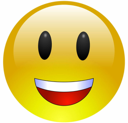

In [105]:
im = Image.open(dest)
im.to_thumb(128,128)

In [97]:
dest

'images/smiley.jpg'

In [45]:
emoji_types = 'smiley','neutral','angry'
path = Path('emojis')

In [47]:
path.exists()

False

In [48]:
if not path.exists():
    path.mkdir()
    for o in emoji_types: #change this
        dest = (path/o)
        dest.mkdir(exist_ok=True)
        results = search_images_bing(key, f'{o} emoji') #change this
        download_images(dest, urls=results.attrgot('content_url'))

In [49]:
fns = get_image_files(path)
fns

(#446) [Path('emojis/smiley/00000001.jpg'),Path('emojis/smiley/00000003.jpg'),Path('emojis/smiley/00000007.png'),Path('emojis/smiley/00000005.png'),Path('emojis/smiley/00000000.png'),Path('emojis/smiley/00000009.jpg'),Path('emojis/smiley/00000008.jpg'),Path('emojis/smiley/00000010.png'),Path('emojis/smiley/00000012.jpg'),Path('emojis/smiley/00000014.jpg')...]

In [50]:
failed = verify_images(fns)
failed

/opt/conda/envs/fastai/lib/python3.7/site-packages/PIL/Image.py:2860: UserWarning: image file could not be identified because WEBP support not installed
  warnings.warn(message)
/opt/conda/envs/fastai/lib/python3.7/site-packages/PIL/Image.py:2860: UserWarning: image file could not be identified because WEBP support not installed
  warnings.warn(message)
/opt/conda/envs/fastai/lib/python3.7/site-packages/PIL/Image.py:2860: UserWarning: image file could not be identified because WEBP support not installed
  warnings.warn(message)
/opt/conda/envs/fastai/lib/python3.7/site-packages/PIL/Image.py:2860: UserWarning: image file could not be identified because WEBP support not installed
  warnings.warn(message)


(#8) [Path('emojis/smiley/00000008.jpg'),Path('emojis/smiley/00000129.png'),Path('emojis/neutral/00000057.jpg'),Path('emojis/neutral/00000127.png'),Path('emojis/neutral/00000136.png'),Path('emojis/angry/00000003.png'),Path('emojis/angry/00000001.png'),Path('emojis/angry/00000129.jpg')]

In [51]:
failed.map(Path.unlink);

### Sidebar: Getting help in jupyter notebooks

### End sidebar

## From data to DataLoaders

In [52]:
emojis = DataBlock(
    blocks=(ImageBlock, CategoryBlock), 
    get_items=get_image_files, 
    splitter=RandomSplitter(valid_pct=0.3, seed=42),
    get_y=parent_label,
    item_tfms=Resize(128))

In [53]:
dls = emojis.dataloaders(path)

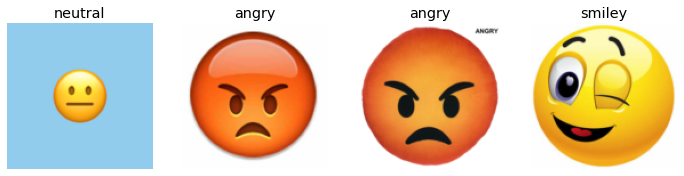

In [54]:
dls.valid.show_batch(max_n=4, nrows=1)


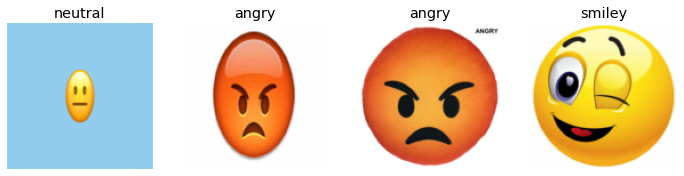

In [55]:
emojis = emojis.new(item_tfms=Resize(128, ResizeMethod.Squish))
dls = emojis.dataloaders(path)
dls.valid.show_batch(max_n=4, nrows=1)

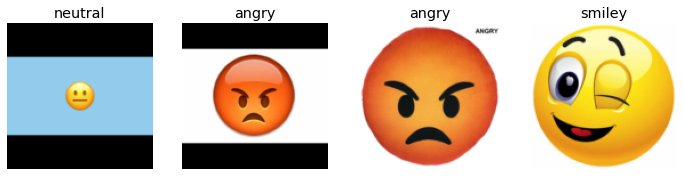

In [56]:
emojis = emojis.new(item_tfms=Resize(128, ResizeMethod.Pad, pad_mode='zeros'))
dls = emojis.dataloaders(path)
dls.valid.show_batch(max_n=4, nrows=1)

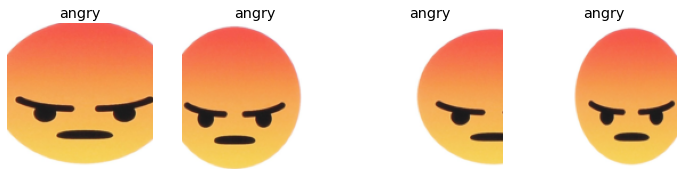

In [57]:
emojis = emojis.new(item_tfms=RandomResizedCrop(128, min_scale=0.3))
dls = emojis.dataloaders(path)
dls.train.get_idxs = lambda: Inf.ones
dls.train.show_batch(max_n=4, nrows=1)

### Data augmentation

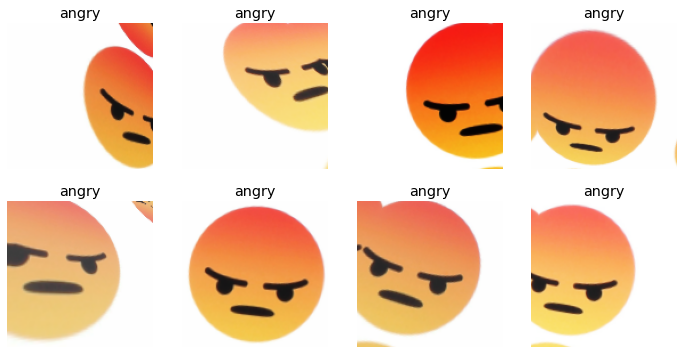

In [58]:
emojis = emojis.new(item_tfms=Resize(128), batch_tfms=aug_transforms(mult=2))
dls = emojis.dataloaders(path)
dls.train.get_idxs = lambda: Inf.ones
dls.train.show_batch(max_n=8, nrows=2)

## Training your model, and using it to clean your data

In [59]:
emojis = emojis.new(
    item_tfms=RandomResizedCrop(128, min_scale=0.3),
    batch_tfms=aug_transforms())
dls = emojis.dataloaders(path)
learn = cnn_learner(dls, resnet34, metrics=error_rate)
learn.fine_tune(8)
interp = ClassificationInterpretation.from_learner(learn)
interp.plot_confusion_matrix()

In [60]:
learn = cnn_learner(dls, resnet34, metrics=error_rate)
learn.fine_tune(8)

epoch,train_loss,valid_loss,error_rate,time
0,1.849894,1.100019,0.404580,00:04


epoch,train_loss,valid_loss,error_rate,time
0,1.133116,0.655060,0.267176,00:04
1,0.901344,0.291219,0.099237,00:04
2,0.758768,0.206540,0.076336,00:04
3,0.673390,0.189191,0.068702,00:04
4,0.587840,0.149852,0.045802,00:04
5,0.529986,0.118924,0.038168,00:04
6,0.471898,0.112788,0.030534,00:04
7,0.427471,0.109541,0.015267,00:04


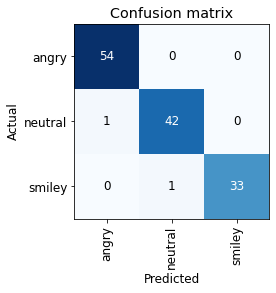

In [61]:
interp = ClassificationInterpretation.from_learner(learn)
interp.plot_confusion_matrix()

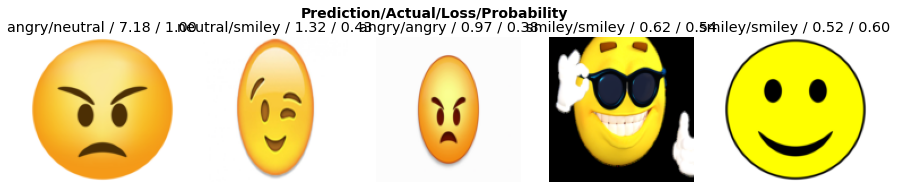

In [62]:
interp.plot_top_losses(5, nrows=1)

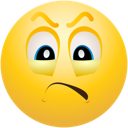

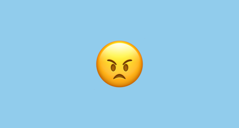

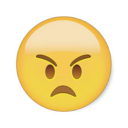

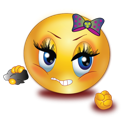

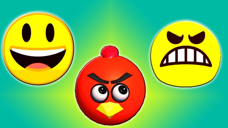

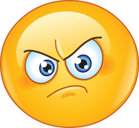

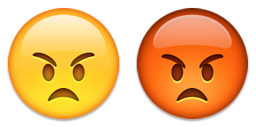

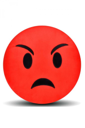

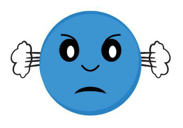

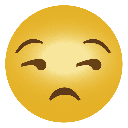

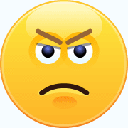

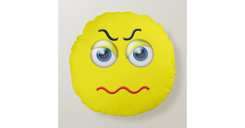

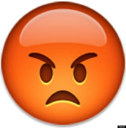

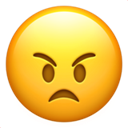

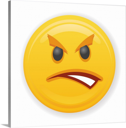

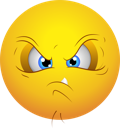

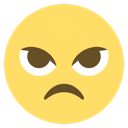

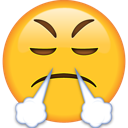

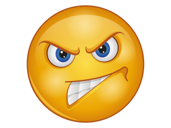

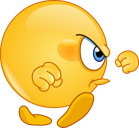

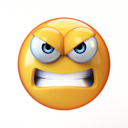

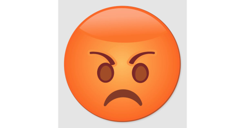

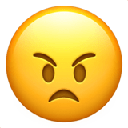

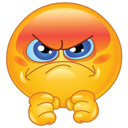

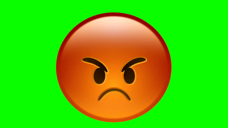

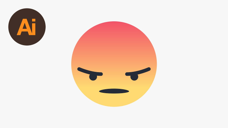

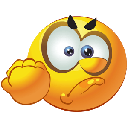

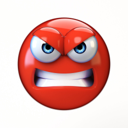

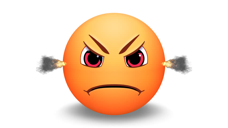

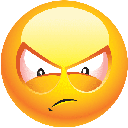

In [63]:
cleaner = ImageClassifierCleaner(learn)
cleaner

In [64]:
#hide
for idx in cleaner.delete(): cleaner.fns[idx].unlink()


In [65]:
learn = cnn_learner(dls, resnet34, metrics=error_rate)
learn.fine_tune(8)
    

epoch,train_loss,valid_loss,error_rate,time
0,1.649644,2.159213,0.580153,00:04


epoch,train_loss,valid_loss,error_rate,time
0,0.984729,0.929842,0.427481,00:04
1,0.913670,0.466578,0.175573,00:04
2,0.772603,0.276955,0.076336,00:04
3,0.665359,0.230995,0.068702,00:04
4,0.566846,0.204002,0.068702,00:04
5,0.500041,0.176092,0.061069,00:04
6,0.446874,0.164610,0.053435,00:04
7,0.402100,0.164048,0.053435,00:04


In [67]:
cleaner.change()

(#0) []

In [ ]:
for idx,cat in cleaner.change(): shutil.move(str(cleaner.fns[idx]), path/cat)

epoch,train_loss,valid_loss,error_rate,time
0,1.699279,1.571570,0.541985,00:04


epoch,train_loss,valid_loss,error_rate,time
0,1.097600,0.781694,0.320611,00:04
1,0.923887,0.363774,0.145038,00:04
2,0.800769,0.172699,0.061069,00:04
3,0.678355,0.101414,0.015267,00:04
4,0.586206,0.098959,0.015267,00:04
5,0.526150,0.098845,0.007634,00:04
6,0.474695,0.093458,0.007634,00:04
7,0.434905,0.093902,0.007634,00:04


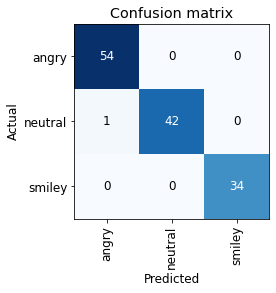

In [71]:
emojis = DataBlock(
    blocks=(ImageBlock, CategoryBlock), 
    get_items=get_image_files, 
    splitter=RandomSplitter(valid_pct=0.3, seed=42),
    get_y=parent_label,
    item_tfms=Resize(128))
emojis = emojis.new(
    item_tfms=RandomResizedCrop(128, min_scale=0.3),
    batch_tfms=aug_transforms())
dls = emojis.dataloaders(path)
learn = cnn_learner(dls, resnet34, metrics=error_rate)
learn.fine_tune(8)
interp = ClassificationInterpretation.from_learner(learn)
interp.plot_confusion_matrix()


In [ ]:
#VBox(children=(Dropdown(options=('smiley', 'neutral', 'angryy'), value='black'), Dropdown(options=('Train', 'Val…

## Turning your model into an online application

### Using the model for inference

In [72]:
learn.export()

In [73]:
path = Path()
path.ls(file_exts='.pkl')

(#1) [Path('export.pkl')]

In [74]:
learn_inf = load_learner(path/'export.pkl')

In [106]:
learn_inf.predict('images/smiley.jpg')

('smiley', tensor(2), tensor([2.2016e-07, 7.2289e-06, 9.9999e-01]))

In [107]:
learn_inf.dls.vocab

(#3) ['angry','neutral','smiley']

### Creating a Notebook app from the model

In [122]:
btn_upload = widgets.FileUpload()
btn_upload

FileUpload(value={}, description='Upload')

In [123]:
#hide
# For the book, we can't actually click an upload button, so we fake it
btn_upload = SimpleNamespace(data = ['images/smiley.jpg'])

In [124]:
btn_upload

namespace(data=['images/smiley.jpg'])

In [125]:
img = PILImage.create(btn_upload.data[-1])

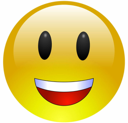

Output()

In [126]:
out_pl = widgets.Output()
out_pl.clear_output()
with out_pl: display(img.to_thumb(128,128))
out_pl

In [127]:
pred,pred_idx,probs = learn_inf.predict(img)

In [128]:
lbl_pred = widgets.Label()
lbl_pred.value = f'Prediction: {pred}; Probability: {probs[pred_idx]:.04f}'
lbl_pred

Label(value='Prediction: smiley; Probability: 1.0000')

In [129]:
btn_run = widgets.Button(description='Classify')
btn_run

Button(description='Classify', style=ButtonStyle())

In [130]:
def on_click_classify(change):
    img = PILImage.create(btn_upload.data[-1])
    out_pl.clear_output()
    with out_pl: display(img.to_thumb(128,128))
    pred,pred_idx,probs = learn_inf.predict(img)
    lbl_pred.value = f'Prediction: {pred}; Probability: {probs[pred_idx]:.04f}'

btn_run.on_click(on_click_classify)

In [132]:
#hide
#Putting back btn_upload to a widget for next cell
btn_upload = widgets.FileUpload()

In [133]:
VBox([widgets.Label('Select your emoji!'), 
      btn_upload, btn_run, out_pl, lbl_pred])

### Turning your notebook into a real app

In [134]:
#hide
!pip install voila
!jupyter serverextension enable voila --sys-prefix

     |████████████████████████████████| 5.9 MB 12.2 MB/s eta 0:00:01
     |████████████████████████████████| 183 kB 31.6 MB/s eta 0:00:01
Enabling: voila
- Writing config: /opt/conda/envs/fastai/etc/jupyter
    - Validating...
      voila 0.1.21 OK
